#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
path = '/content/drive/MyDrive/KT Aivle/Mini Project 6-1/'

### **(2) 라이브러리 설치 및 불러오기**

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [128]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [129]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [130]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [131]:
oil_price.head(3)

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66


In [132]:
orders.head(3)

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875


In [133]:
sales.head(3)

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7


In [134]:
products.head(3)

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23


In [135]:
stores.head(3)

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4
1,2,Saint Paul,\tMinnesota,4
2,3,Saint Paul,\tMinnesota,4


## **(1) 상품 : 3 - Beverage**

## **(2) 상품 : 12 - Milk**

## **(3) 상품 : 42 - Agricultural products**

In [136]:
# Store 44 일별 매장별 고객 방문 수
my_orders = orders.loc[(orders['Store_ID'] == 44)].reset_index(drop=True)

# Store 44 판매 정보
my_sales = sales.loc[sales['Store_ID'] == 44].reset_index(drop=True)

# Store 44 Agricultural products 판매 정보
a_sales = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)].reset_index(drop=True)

# Store 44 매장 기본 정보
my_stores = stores.loc[(stores['Store_ID'] == 44)].reset_index(drop=True)

In [137]:
# 모델링에 사용할 데이터셋 생성
a_data = a_sales.copy()

In [138]:
a_data.head(5)

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,44,51.0,42
1,2014-01-02,44,76.0,42
2,2014-01-03,44,74.0,42
3,2014-01-04,44,78.0,42
4,2014-01-05,44,88.0,42


- 필요없는 변수 제거

In [139]:
a_data.drop(columns = ['Store_ID', 'Product_ID'], inplace=True)

In [140]:
a_data.head(5)

,Date,Qty
0,2014-01-01,51.0
1,2014-01-02,76.0
2,2014-01-03,74.0
3,2014-01-04,78.0
4,2014-01-05,88.0


- y값 추가

In [141]:
# 타겟 변수가 될 판매량에 결측치 없음 확인
len(a_data[a_data['Qty'] == 0])

0

In [142]:
# 타겟변수: # Lead Time이 2이므로 이틀 뒤 판매량 예측이 목표 → 날짜를 기준으로 이틀 뒤 판매량(y) 추가
a_data['y'] = a_data['Qty'].shift(-2)
a_data.tail(5)

,Date,Qty,y
1150,2017-02-24,91.0,108.0
1151,2017-02-25,105.0,78.0
1152,2017-02-26,108.0,87.0
1153,2017-02-27,78.0,NaN
1154,2017-02-28,87.0,NaN


- orders

In [143]:
# 데이터셋에 방문자 수 데이터 추가 (날짜 기준으로)
a_data = pd.merge(a_data, my_orders, on='Date', how='left')
a_data.drop(columns = ['Store_ID'], inplace=True)

a_data.head(5)

,Date,Qty,y,CustomerCount
0,2014-01-01,51.0,74.0,NaN
1,2014-01-02,76.0,78.0,4422.0
2,2014-01-03,74.0,88.0,4167.0
3,2014-01-04,78.0,65.0,5341.0
4,2014-01-05,88.0,78.0,5123.0


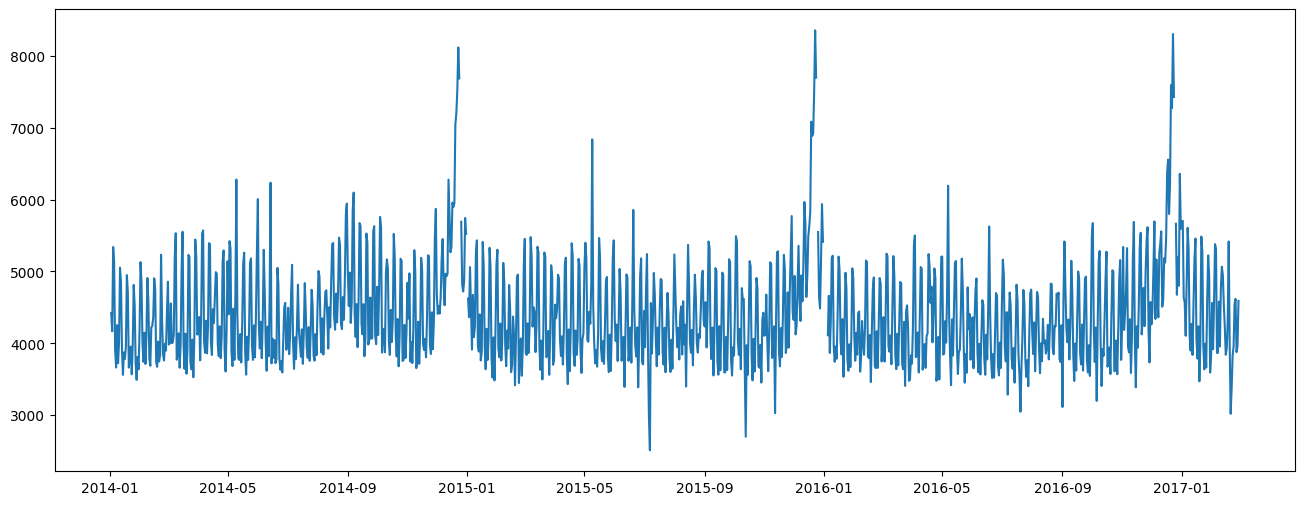

In [144]:
# 일별 방문자 데이터 확인
plt.figure(figsize=(16, 6))
plt.plot('Date', 'CustomerCount', data=a_data)
plt.show()

In [145]:
a_data.loc[a_data['CustomerCount'].isnull(), 'Date']

0      2014-01-01
358    2014-12-25
365    2015-01-01
723    2015-12-25
730    2016-01-01
732    2016-01-03
733    2016-01-04
1089   2016-12-25
1096   2017-01-01
Name: Date, dtype: datetime64[ns]

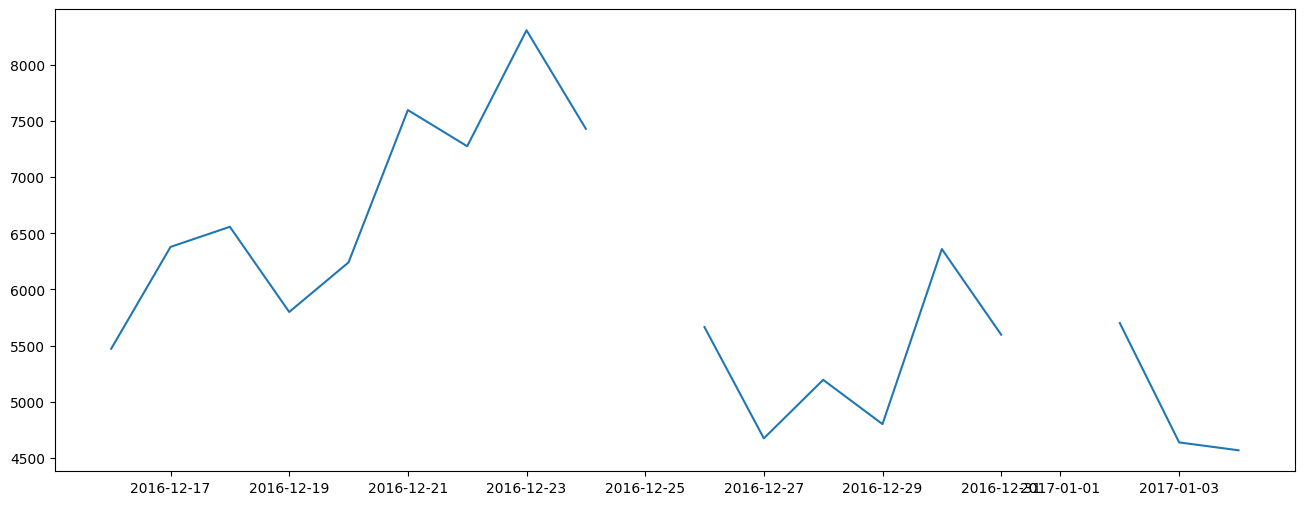

In [146]:
# 결측치 확인
plt.figure(figsize=(16, 6))
plt.plot('Date', 'CustomerCount', data=a_data[1080:1100])
plt.show()

In [147]:
# 선형보간법으로 결측치 채움
a_data['CustomerCount'] = a_data['CustomerCount'].interpolate(method='linear')

- oil_price

In [148]:
# 데이터셋에 유가 데이터 추가 (날짜 기준으로)
a_data = pd.merge(a_data, oil_price, on='Date', how='left')

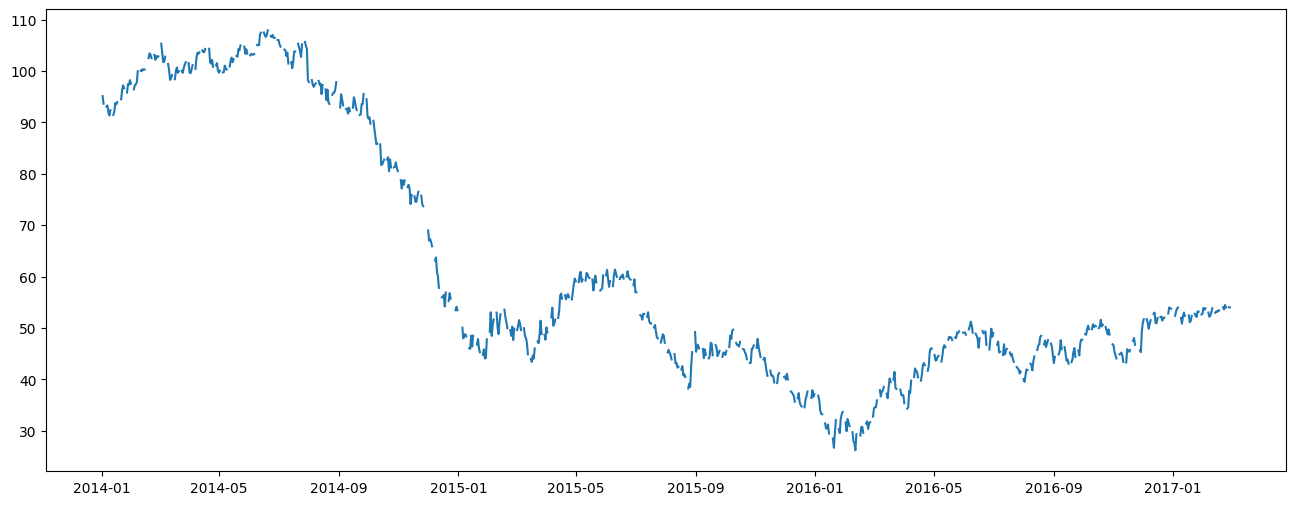

In [149]:
# 유가 데이터 결측치 확인
plt.figure(figsize=(16, 6))
plt.plot('Date', 'WTI_Price', data=a_data)
plt.show()

In [150]:
# 시계열 데이터이므로 선형보간법으로 결측치 채움
a_data['WTI_Price'] = a_data['WTI_Price'].interpolate(method='linear')

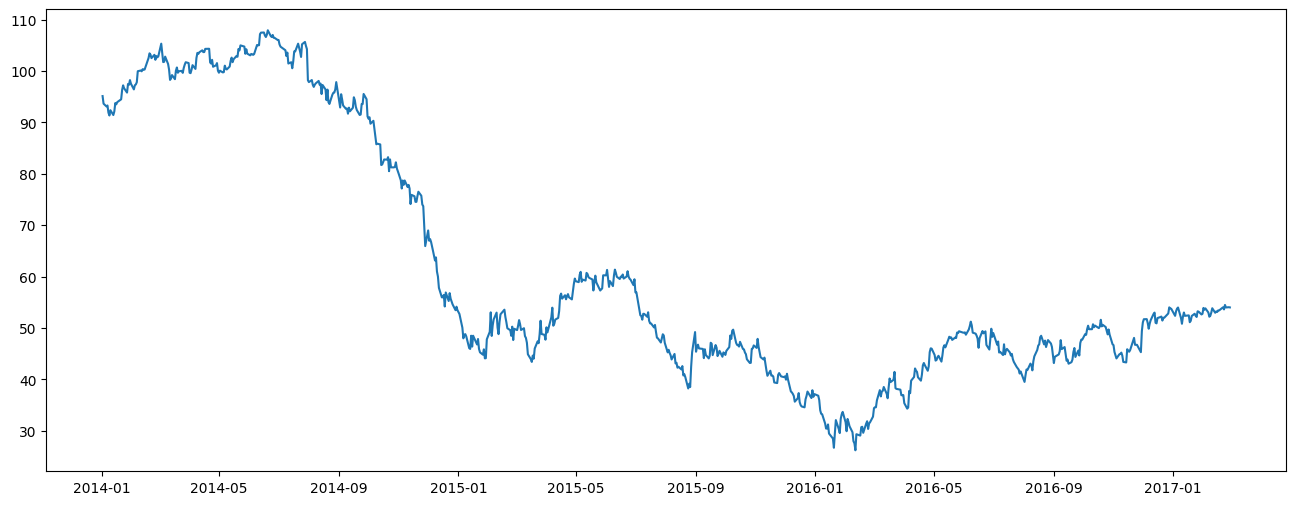

In [151]:
# 결측치 채운 뒤 그래프 확인
plt.figure(figsize=(16, 6))
plt.plot('Date', 'WTI_Price', data=a_data)
plt.show()

In [152]:
# 하루 전 유가, 7일 전 유가, 7일 간 이동평균 유가 계산해 열 추가

# 하루 전
a_data['Prev_Day_WTI_Price'] = a_data['WTI_Price'].shift(1)

# 일주일 전
a_data['One_Week_Ago_WTI_Price'] = a_data['WTI_Price'].shift(7)

# 7일 간 이동평균
a_data['7MA_WTI_Price'] = a_data['WTI_Price'].rolling(window = 7).mean()
a_data.head(10)

,Date,Qty,y,CustomerCount,WTI_Price,Prev_Day_WTI_Price,One_Week_Ago_WTI_Price,7MA_WTI_Price
0,2014-01-01,51.0,74.0,NaN,NaN,NaN,NaN,NaN
1,2014-01-02,76.0,78.0,4422.0,95.14,NaN,NaN,NaN
2,2014-01-03,74.0,88.0,4167.0,93.66,95.14,NaN,NaN
3,2014-01-04,78.0,65.0,5341.0,93.48,93.66,NaN,NaN
4,2014-01-05,88.0,78.0,5123.0,93.30,93.48,NaN,NaN
5,2014-01-06,65.0,73.0,3917.0,93.12,93.30,NaN,NaN
6,2014-01-07,78.0,78.0,3663.0,93.31,93.12,NaN,NaN
7,2014-01-08,73.0,96.0,4254.0,91.90,93.31,NaN,93.415714
8,2014-01-09,78.0,67.0,3723.0,91.36,91.90,95.14,92.875714
9,2014-01-10,96.0,93.0,4010.0,92.39,91.36,93.66,92.694286


In [153]:
# TODO: 유가 범주화 (비쌈/중간/쌈)

- products

In [154]:
# TODO
s_sales = my_sales[my_sales['Product_ID'] == 32]
e_sales = my_sales[my_sales['Product_ID'] == 10]
m_sales = my_sales[my_sales['Product_ID'] == 24]

- 새 변수 추가

In [155]:
# 연도와 월, 요일, 계절을 추출하여 새로운 열로 추가

# 연도
a_data['Year'] = a_data['Date'].dt.year

# 월
a_data['Month'] = a_data['Date'].dt.month

# 요일
a_data['WeekDay'] = a_data['Date'].dt.weekday # 월(0)~일(6)

# 계절
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    elif month in [12, 1, 2]:
        return 'Winter'

a_data['Season'] = a_data['Date'].dt.month.apply(get_season)

# 계절 변수 가변수화
a_data = pd.get_dummies(a_data, columns = ['Season'], drop_first = True, dtype = int)

최종 데이터

In [156]:
# 날짜를 index로
a_data.set_index('Date', inplace = True)

In [157]:
# 앞뒤 결측치 제거
a_data.dropna(how='any', inplace = True)

In [158]:
a_data

,Qty,y,CustomerCount,WTI_Price,Prev_Day_WTI_Price,One_Week_Ago_WTI_Price,7MA_WTI_Price,Year,Month,WeekDay,Season_Spring,Season_Summer,Season_Winter
Date,,,,,,,,,,,,,
2014-01-09,78.0,67.0,3723.0,91.360000,91.900000,95.1400,92.875714,2014,1,3,0,0,1
2014-01-10,96.0,93.0,4010.0,92.390000,91.360000,93.6600,92.694286,2014,1,4,0,0,1
2014-01-11,67.0,59.0,5053.0,92.076667,92.390000,93.4800,92.493810,2014,1,5,0,0,1
2014-01-12,93.0,63.0,4852.0,91.763333,92.076667,93.3000,92.274286,2014,1,6,0,0,1
2014-01-13,59.0,53.0,3913.0,91.450000,91.763333,93.1200,92.035714,2014,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-22,72.0,91.0,3834.0,53.610000,54.020000,53.1100,53.656429,2017,2,2,0,0,1
2017-02-23,98.0,105.0,3955.0,54.480000,53.610000,53.4100,53.809286,2017,2,3,0,0,1
2017-02-24,91.0,108.0,4549.0,53.990000,54.480000,53.4100,53.892143,2017,2,4,0,0,1


In [159]:
a_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1145 entries, 2014-01-09 to 2017-02-26
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Qty                     1145 non-null   float64
 1   y                       1145 non-null   float64
 2   CustomerCount           1145 non-null   float64
 3   WTI_Price               1145 non-null   float64
 4   Prev_Day_WTI_Price      1145 non-null   float64
 5   One_Week_Ago_WTI_Price  1145 non-null   float64
 6   7MA_WTI_Price           1145 non-null   float64
 7   Year                    1145 non-null   int32  
 8   Month                   1145 non-null   int32  
 9   WeekDay                 1145 non-null   int32  
 10  Season_Spring           1145 non-null   int64  
 11  Season_Summer           1145 non-null   int64  
 12  Season_Winter           1145 non-null   int64  
dtypes: float64(7), int32(3), int64(3)
memory usage: 111.8 KB


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [160]:
x = a_data.drop('y', axis = 1)
y = a_data.loc[:, 'y']

In [161]:
# x
scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)

In [162]:
x

array([[0.21854305, 0.20738588, 0.79708904, ..., 0.        , 0.        ,
        1.        ],
       [0.33774834, 0.25645409, 0.80968689, ..., 0.        , 0.        ,
        1.        ],
       [0.14569536, 0.43477518, 0.80585453, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.30463576, 0.3486066 , 0.34001957, ..., 0.        , 0.        ,
        1.        ],
       [0.39735099, 0.36057446, 0.34022342, ..., 0.        , 0.        ,
        1.        ],
       [0.41721854, 0.23371516, 0.34042727, ..., 0.        , 0.        ,
        1.        ]])

In [163]:
# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [164]:
y

array([[0.14569536],
       [0.31788079],
       [0.09271523],
       ...,
       [0.41721854],
       [0.21854305],
       [0.2781457 ]])

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

### **2) 모델링**

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

### **2) 모델링**

## **(3) 상품 : 42 - Agricultural products**

In [165]:
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train.reshape(-1))
    y_val = pd.Series(y_val.reshape(-1))
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **1) 데이터 준비**

In [166]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

In [167]:
nfeatures = x_train.shape[1]
nfeatures

12

### **2) 모델링**

In [168]:
clear_session()

model1 = Sequential([Dense(8, input_shape = (nfeatures,), activation = 'relu'),
                    Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.0001) ,loss='mse')

In [169]:
hist = model1.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)).history

Epoch 1/50
34/34 [==============================] - 2s 13ms/step - loss: 0.5789 - val_loss: 0.1473
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.5110 - val_loss: 0.1110
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 0.4500 - val_loss: 0.0818
Epoch 4/50
34/34 [==============================] - 0s 5ms/step - loss: 0.3954 - val_loss: 0.0595
Epoch 5/50
34/34 [==============================] - 0s 5ms/step - loss: 0.3470 - val_loss: 0.0430
Epoch 6/50
34/34 [==============================] - 0s 6ms/step - loss: 0.3051 - val_loss: 0.0318
Epoch 7/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2684 - val_loss: 0.0255
Epoch 8/50
34/34 [==============================] - 0s 6ms/step - loss: 0.2372 - val_loss: 0.0229
Epoch 9/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2104 - val_loss: 0.0234
Epoch 10/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1878 - val_loss: 0.0261
Epoch 11/50
34/34 

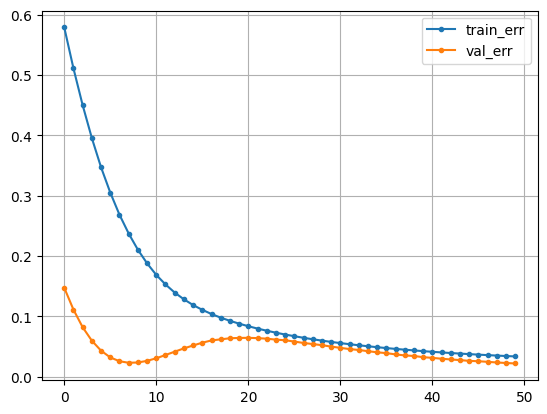

In [170]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [171]:
s_pred = model1.predict(x_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(s_pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 10ms/step


In [172]:
# 평가
print('RMSE :', mean_squared_error(y_val, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_val, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_val, s_pred))
print('R2  :', r2_score(y_val, s_pred))

RMSE : 0.1475191329362948
MAE : 0.1146146770377559
MAPE: 0.6474951290297473
R2  : -1.1573320283591975


In [173]:
s_pred.shape

(60, 1)

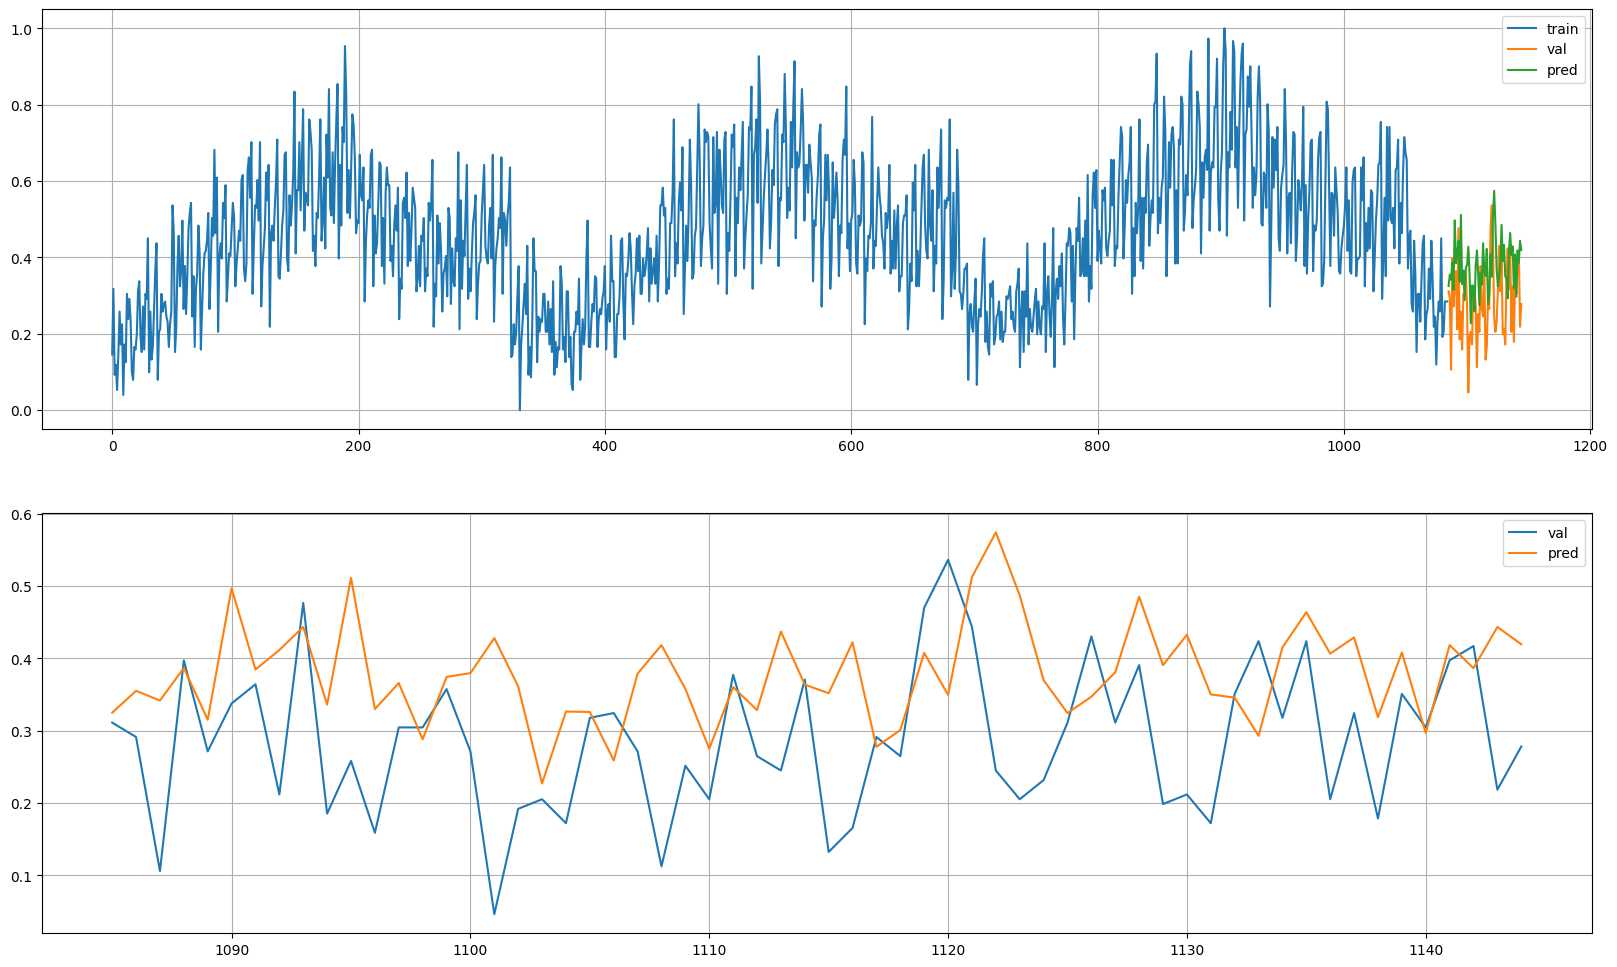

In [174]:
plot_model_result(y_train, y_val, s_pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [175]:
# 2차원 → 3차원 변환 (for LSTM, CNN)
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [176]:
timesteps = 7
x2, y2 = temporalize(pd.DataFrame(x), pd.DataFrame(y), timesteps)

In [177]:
val_size = 7 * nfeatures
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = val_size, shuffle = False)

In [201]:
x_train

array([[[0.21854305, 0.20738588, 0.79708904, ..., 0.        ,
         0.        , 1.        ],
        [0.33774834, 0.25645409, 0.80968689, ..., 0.        ,
         0.        , 1.        ],
        [0.14569536, 0.43477518, 0.80585453, ..., 0.        ,
         0.        , 1.        ],
        ...,
        [0.09271523, 0.23987006, 0.79818982, ..., 0.        ,
         0.        , 1.        ],
        [0.1192053 , 0.17951787, 0.80675147, ..., 0.        ,
         0.        , 1.        ],
        [0.05298013, 0.23286032, 0.82668787, ..., 0.        ,
         0.        , 1.        ]],

       [[0.33774834, 0.25645409, 0.80968689, ..., 0.        ,
         0.        , 1.        ],
        [0.14569536, 0.43477518, 0.80585453, ..., 0.        ,
         0.        , 1.        ],
        [0.31788079, 0.40041033, 0.80202218, ..., 0.        ,
         0.        , 1.        ],
        ...,
        [0.1192053 , 0.17951787, 0.80675147, ..., 0.        ,
         0.        , 1.        ],
        [0.0

* **모델링**

In [178]:
n_features = x_train.shape[2]

clear_session()

model2 = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                    Dense(1)])

model2.compile(optimizer = Adam(learning_rate = 0.001), loss='mse')

In [179]:
x_train.shape, y_train.shape

((1055, 7, 12), (1055, 1))

In [180]:
hist = model2.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val)).history

Epoch 1/50
33/33 [==============================] - 8s 52ms/step - loss: 0.0483 - val_loss: 0.0206
Epoch 2/50
33/33 [==============================] - 0s 12ms/step - loss: 0.0187 - val_loss: 0.0195
Epoch 3/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0164 - val_loss: 0.0176
Epoch 4/50
33/33 [==============================] - 1s 16ms/step - loss: 0.0153 - val_loss: 0.0153
Epoch 5/50
33/33 [==============================] - 0s 14ms/step - loss: 0.0144 - val_loss: 0.0149
Epoch 6/50
33/33 [==============================] - 1s 16ms/step - loss: 0.0137 - val_loss: 0.0235
Epoch 7/50
33/33 [==============================] - 1s 15ms/step - loss: 0.0134 - val_loss: 0.0215
Epoch 8/50
33/33 [==============================] - 1s 17ms/step - loss: 0.0127 - val_loss: 0.0205
Epoch 9/50
33/33 [==============================] - 0s 14ms/step - loss: 0.0122 - val_loss: 0.0248
Epoch 10/50
33/33 [==============================] - 1s 19ms/step - loss: 0.0120 - val_loss: 0.0257
Epoch 11/

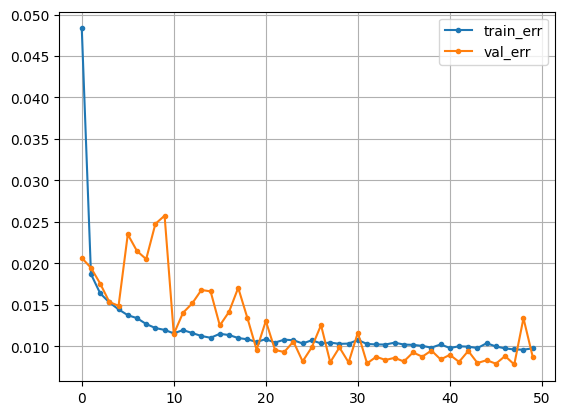

In [181]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [182]:
s_pred = model2.predict(x_val)

3/3 [==============================] - 0s 5ms/step


In [183]:
# 평가
print('RMSE :', mean_squared_error(y_val, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_val, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_val, s_pred))
print('R2  :', r2_score(y_val, s_pred))

RMSE : 0.09345759635140762
MAE : 0.07568024956242063
MAPE: 0.38070574069310004
R2  : 0.07261459985879437


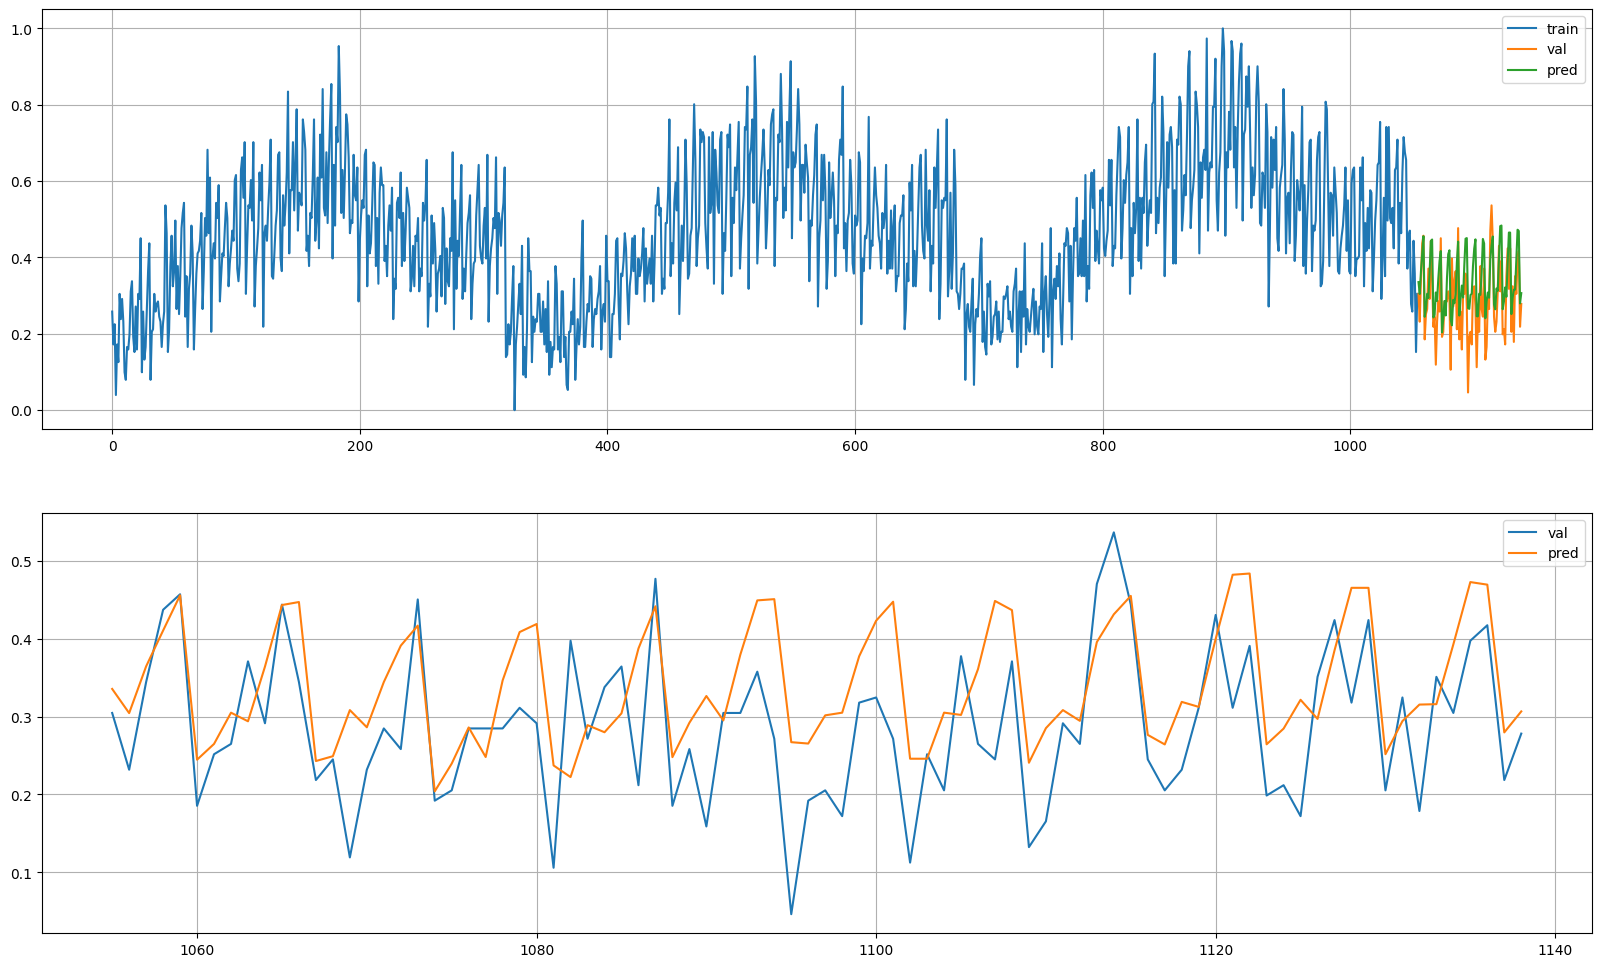

In [196]:
plot_model_result(y_train, y_val, s_pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

### **2) 상품 : 12 - Milk**

### **3) 상품 : 42 - Agricultural products**

* **모델링**

In [206]:
n_features

12

In [186]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'), # (Kernel 32열, Kernel (5행), strides defalut는 1, padding은 그냥 same으로 줘야 같은 사이즈 나옴)
                    Flatten(), # 마지막 Dense 레이어와 연결하기 전에 꼭 해줘야 함
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [187]:
hist = model3.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val)).history

Epoch 1/30
33/33 [==============================] - 1s 9ms/step - loss: 0.0448 - val_loss: 0.0178
Epoch 2/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0114
Epoch 3/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0122
Epoch 4/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0160
Epoch 5/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 6/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 7/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 8/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 9/30
33/33 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0184
Epoch 10/30
33/33 [==============================] - 0s 4ms/step - loss: 0.0088 - val_loss: 0.0120
Epoch 11/30
33/33 [

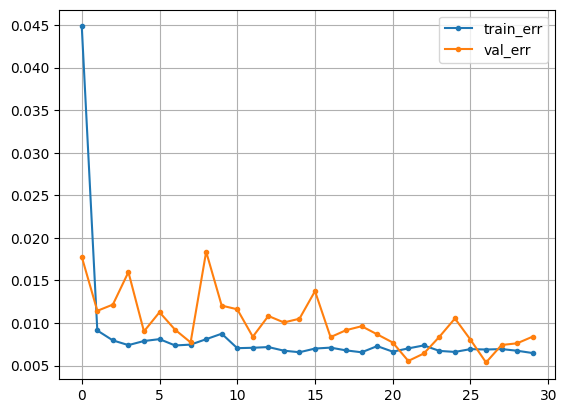

In [188]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [189]:
s_pred = model3.predict(x_val)

3/3 [==============================] - 0s 4ms/step


In [190]:
# 평가
print('RMSE :', mean_squared_error(y_val, s_pred)**(1/2))
print('MAE :', mean_absolute_error(y_val, s_pred))
print('MAPE:', mean_absolute_percentage_error(y_val, s_pred))
print('R2  :', r2_score(y_val, s_pred))

RMSE : 0.0916930822070571
MAE : 0.0744541847049833
MAPE: 0.36467430596297334
R2  : 0.10730277811150479


In [191]:
s_pred.shape

(84, 1)

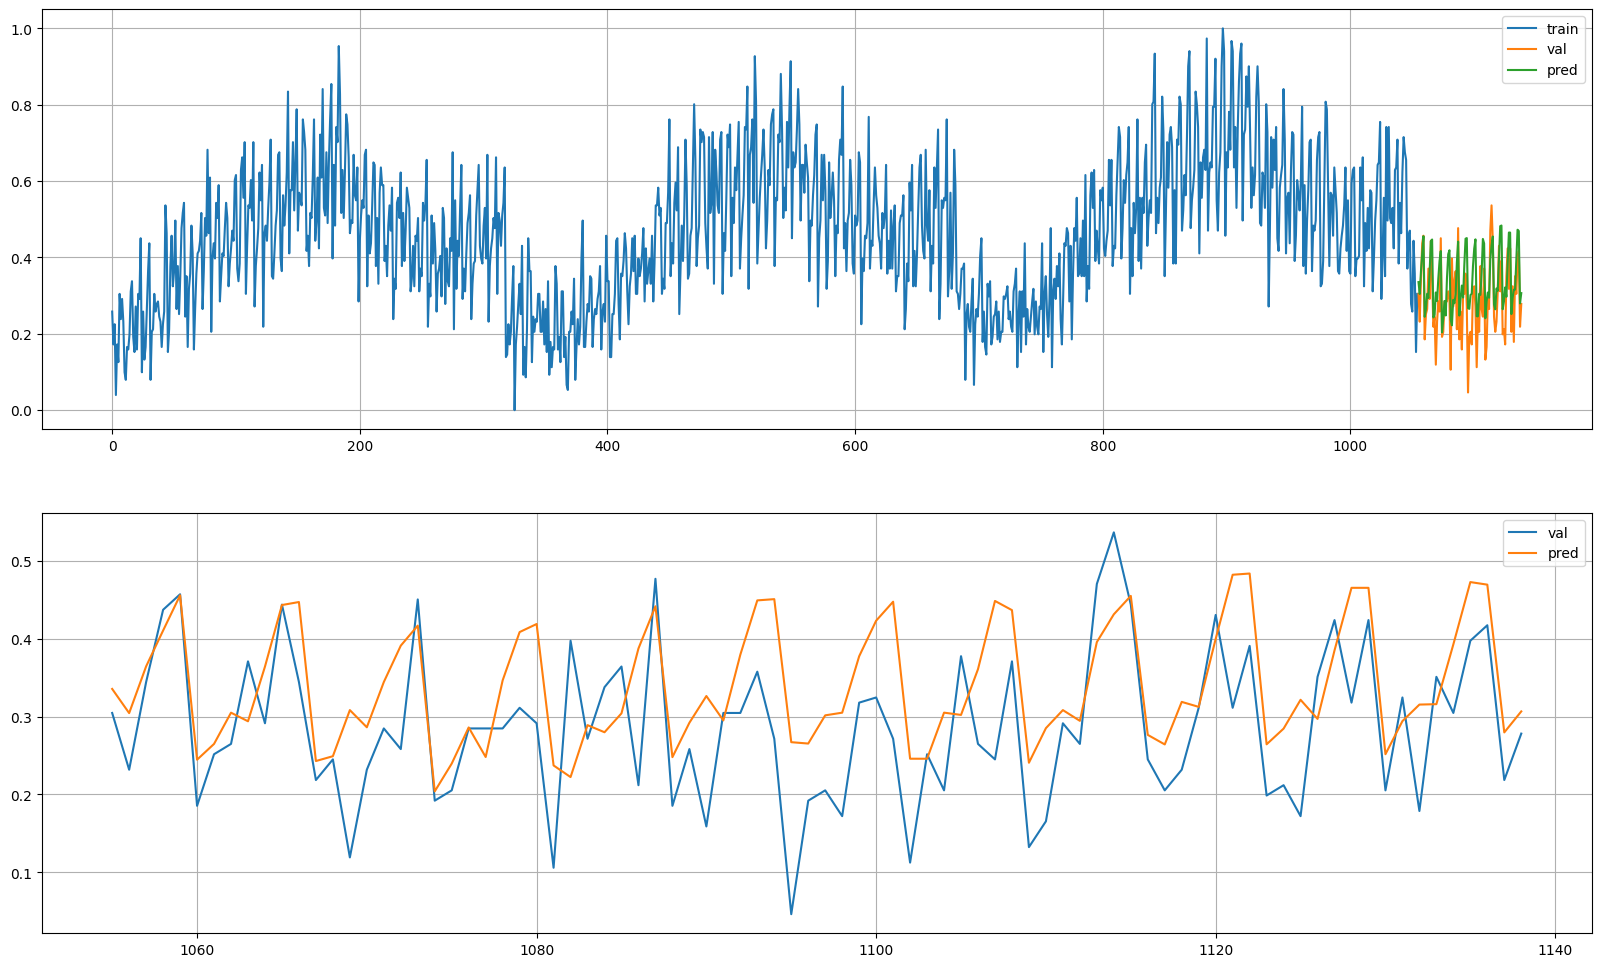

In [192]:
plot_model_result(y_train, y_val, s_pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [193]:
# 데이터 저장
a_data.to_pickle('a_data.pkl')